# Начало

## Ряд

            Unnamed: 0  target_price
dt                                  
2018-01-01           0       35600.0
2018-01-08           1       35600.0
2018-01-15           2       35300.0
2018-01-22           3       34500.0
2018-01-29           4       33700.0


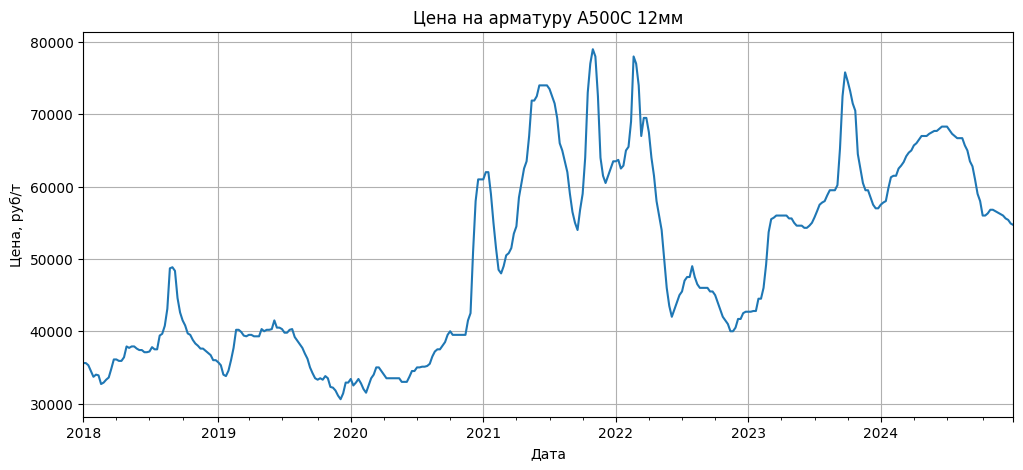

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df_price = pd.read_csv("./data/reinforcement_prices.csv")
df_price['dt'] = pd.to_datetime(df_price['dt'])
df_price = df_price.set_index('dt').sort_index()
df_price = df_price.rename(columns={"price_reinforcement_a500c_12mm_fca_Moscow": "target_price"})

print(df_price.head())

df_price['target_price'].plot(figsize=(12, 5), title="Цена на арматуру A500C 12мм")
plt.ylabel("Цена, руб/т")
plt.xlabel("Дата")
plt.grid(True)
plt.show()

## all_prices features

In [27]:
df_quotes = pd.read_csv("./data/reinforcement_all_prices.csv")

df_quotes['value_date'] = pd.to_datetime(df_quotes['value_date'])
fill_values = [
    'Cырье_концентрат_коксующегося_угля1',
    'Cырье_концентрат_коксующегося_угля2',
    'Cырье_концентрат_коксующегося_угля3',
    'Cырье_концентрат_коксующегося_угля4'
]
nan_indices = df_quotes[df_quotes['basis'].isna()].index

for i, idx in enumerate(nan_indices):
    df_quotes.loc[idx, 'basis'] = fill_values[i % len(fill_values)]

df_quotes = df_quotes[['basis', 'value_date',  'value']]
df_quotes_wide = df_quotes.pivot_table(index='value_date', columns='basis', values='value').sort_index()

убираем, где дофига пропущено, остальные линейно интерполируем

In [28]:
target = df_quotes_wide["Арматура, А500С 12мм, FCA склад трейдера Москва, руб./т, с НДС"]
# df_quotes_wide.drop("Арматура, А500С 12мм, FCA склад трейдера Москва, руб./т, с НДС", axis=1, inplace=True)

missing_values = df_quotes_wide.isna().sum()
threshold = 0.3
df_wide_clean = df_quotes_wide.loc[:, missing_values / len(df_quotes_wide) < threshold]
df_wide_clean = df_wide_clean.interpolate(method='linear', limit_direction='both')

In [29]:
df = df_wide_clean
df.to_csv('test1.csv')

сдвигаю все на 1, назад, так как нам известны только прошлые данные

In [30]:
df = df.shift(1)

добавляю побольше фичей лагов

In [31]:
colnames = list(df.columns)
for col in colnames:
    for i in range(1,8):
        df[f'{col}_{i}'] = df[col].shift(i)

In [32]:
df['target'] = target

In [33]:
df = df.dropna()

## простые мл модели

In [34]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge

In [35]:
def train_and_test(df, models, colors, pred_size):
    test = df.tail(pred_size)
    train = df.iloc[:-pred_size]
    X_train = train.drop(columns='target')
    y_train = train['target']
    X_test = test.drop(columns='target')
    y_test = test['target']
    predictions = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        predictions[name] = pred

    for name, pred in predictions.items():
        mae = mean_absolute_error(y_test, pred)
        rmse = root_mean_squared_error(y_test, pred)
        print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, y_test, label='Real', color='blue', linestyle='--', marker='o', linewidth=3, markersize=8)
    colors = ['red', 'green', 'purple', 'yellow']
    for i, model in enumerate(models.keys()):
        plt.plot(test.index, predictions[model], label=model, color=colors[i], linestyle='-', marker='x')
    plt.ylabel("Цена, руб/т")
    plt.xlabel("Дата")
    plt.title("Цена на арматуру A500C 12мм")
    plt.legend()
    plt.grid(True)
    plt.show()


Cross-validation (TimeSeriesSplit) results:
Random Forest CV -> MAE: 4089.23, RMSE: 5590.35
XGBoost CV -> MAE: 5354.26, RMSE: 6997.64
Lasso CV -> MAE: 5140.53, RMSE: 6372.02
ARIMA CV -> MAE: 11270.31, RMSE: 13485.26

Test set results:
Random Forest -> MAE: 1115.81, RMSE: 1204.15
XGBoost -> MAE: 923.87, RMSE: 1054.84
Lasso -> MAE: 2926.19, RMSE: 3793.06
ARIMA -> MAE: 1061.70, RMSE: 1243.96


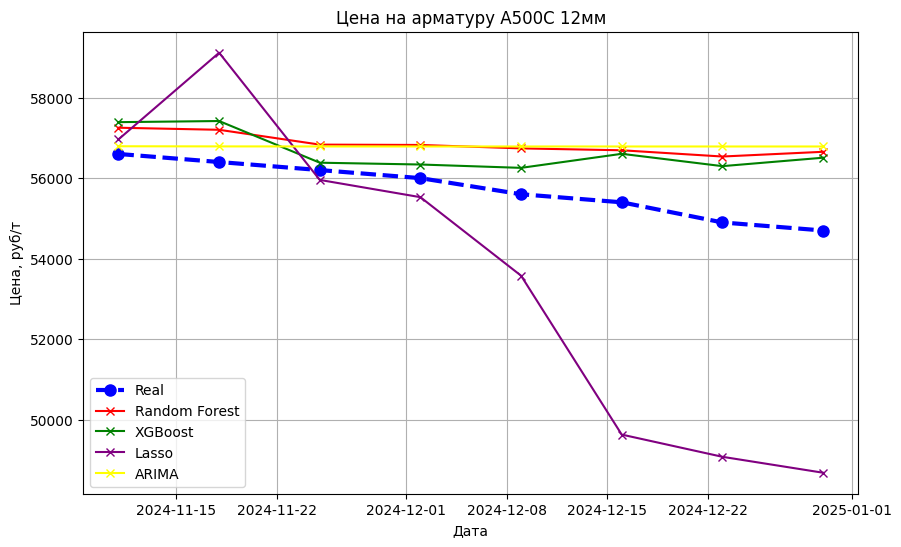

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def cross_val_mae_rmse(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    maes, rmses = [], []
    for train_idx, test_idx in tscv.split(X):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        preds = model.predict(X.iloc[test_idx])
        maes.append(mean_absolute_error(y.iloc[test_idx], preds))
        rmses.append(root_mean_squared_error(y.iloc[test_idx], preds))
    return np.mean(maes), np.mean(rmses)

def arima_cross_val(series, order=(1,1,1), n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    maes, rmses = [], []
    for train_idx, test_idx in tscv.split(series):
        train = series.iloc[train_idx]
        test = series.iloc[test_idx]
        try:
            model = ARIMA(train, order=order)
            model_fit = model.fit()
            preds = model_fit.forecast(steps=len(test))
            maes.append(mean_absolute_error(test, preds))
            rmses.append(root_mean_squared_error(test, preds))
        except:
            # Если не сходится, пропускаем этот сплит
            continue
    return np.mean(maes), np.mean(rmses)

def train_and_test(df, models, colors, pred_size):
    test = df.tail(pred_size)
    train = df.iloc[:-pred_size]
    X_train = train.drop(columns='target')
    y_train = train['target']
    X_test = test.drop(columns='target')
    y_test = test['target']
    predictions = {}

    print("Cross-validation (TimeSeriesSplit) results:")
    for name, model in models.items():
        mae, rmse = cross_val_mae_rmse(model, X_train, y_train, n_splits=5)
        print(f"{name} CV -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # ARIMA cross-validation (используем только y_train)
    arima_order = (1,1,1)  # можно подобрать вручную или автоматически
    arima_mae, arima_rmse = arima_cross_val(y_train, order=arima_order, n_splits=5)
    print(f"ARIMA CV -> MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}")

    # Fit/predict final models
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        predictions[name] = pred

    # ARIMA fit/predict на всем train
    arima_model = ARIMA(y_train, order=arima_order)
    arima_fit = arima_model.fit()
    arima_pred = arima_fit.forecast(steps=pred_size)
    predictions['ARIMA'] = arima_pred

    print("\nTest set results:")
    for name, pred in predictions.items():
        mae = mean_absolute_error(y_test, pred)
        rmse = root_mean_squared_error(y_test, pred)
        print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, y_test, label='Real', color='blue', linestyle='--', marker='o', linewidth=3, markersize=8)
    model_colors = colors + ['black']
    for i, name in enumerate(predictions.keys()):
        plt.plot(test.index, predictions[name], label=name, color=model_colors[i], linestyle='-', marker='x')
    plt.ylabel("Цена, руб/т")
    plt.xlabel("Дата")
    plt.title("Цена на арматуру A500C 12мм")
    plt.legend()
    plt.grid(True)
    plt.show()

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'XGBoost': XGBRegressor(n_estimators=100),
    'Lasso': Lasso(alpha=0.1)
}
colors = ['red', 'green', 'purple', 'yellow']

train_and_test(df, models, colors, 8)


In [37]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'XGBoost': XGBRegressor(n_estimators=100),
    'Lasso': Lasso(alpha=0.1)
    # 'Ridge': Ridge(alpha=0.1)
}
colors = ['red', 'green', 'purple', 'yellow']

In [38]:
df

basis,"3А, FOB РФ Черное море, $/т","3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС","3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","3А, РФ FCA ж/д Московский регион, руб./т, без НДС","3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС","CFR NOLA США, $/т","CFR Италия, $/т","CFR Китай, $/т",...,"Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т_6","Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т_7","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_1","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_2","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_3","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_4","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_5","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_6","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_7",target
value_date,,,,,,,,,,,,,,,,,,,,,
2018-02-26,305.0,14657.0,15580.0,15976.0,15240.0,14665.0,14739.0,381.0,346.0,323.0,...,126.0,126.0,80.0,80.0,80.0,77.0,77.0,77.0,77.0,32900.0
2018-03-05,315.0,14965.0,15836.0,16356.0,15496.0,15231.0,15040.0,388.0,355.5,323.0,...,126.0,126.0,80.0,80.0,80.0,80.0,77.0,77.0,77.0,33300.0
2018-03-12,325.0,15567.0,16001.0,16731.0,15536.0,15612.0,15040.0,395.0,358.0,323.0,...,126.0,126.0,74.0,80.0,80.0,80.0,80.0,77.0,77.0,33600.0
2018-03-19,325.0,15440.0,16421.0,17007.0,16989.0,15775.0,15271.0,403.0,371.5,323.0,...,127.0,126.0,74.0,74.0,80.0,80.0,80.0,80.0,77.0,34800.0
2018-03-26,323.0,15583.0,16692.0,17211.0,17904.0,16100.0,15404.0,411.0,374.0,323.0,...,127.0,127.0,74.0,74.0,74.0,80.0,80.0,80.0,80.0,36100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-02,276.0,24695.0,27257.0,27210.0,26993.0,24531.0,23441.0,463.0,362.0,350.0,...,117.0,117.0,90.0,90.0,90.0,89.0,89.0,89.0,89.0,56000.0
2024-12-09,273.0,23717.0,27652.0,27601.0,27693.0,24575.0,23557.0,463.0,357.5,350.0,...,117.0,117.0,90.0,90.0,90.0,90.0,89.0,89.0,89.0,55600.0
2024-12-16,279.0,24793.0,27788.0,27109.0,27837.0,24237.0,23168.0,438.0,365.0,350.0,...,117.0,117.0,98.0,90.0,90.0,90.0,90.0,89.0,89.0,55400.0


Cross-validation (TimeSeriesSplit) results:
Random Forest CV -> MAE: 4054.82, RMSE: 5492.57
XGBoost CV -> MAE: 4370.65, RMSE: 5911.35
Lasso CV -> MAE: 5532.17, RMSE: 6973.88
ARIMA CV -> MAE: 12122.40, RMSE: 14179.27

Test set results:
Random Forest -> MAE: 1294.19, RMSE: 1484.01
XGBoost -> MAE: 1115.14, RMSE: 1295.45
Lasso -> MAE: 2498.12, RMSE: 3125.29
ARIMA -> MAE: 5679.36, RMSE: 6527.50


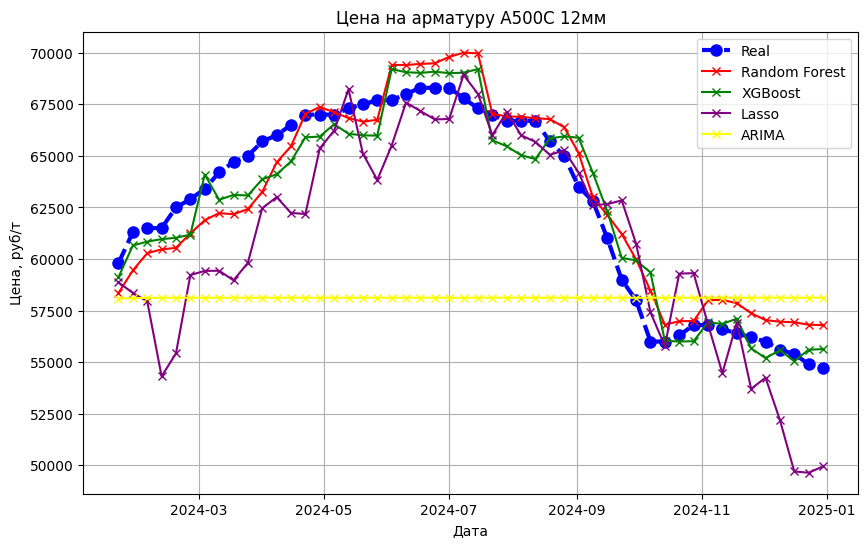

In [39]:
train_and_test(df, models, colors, 50)

последний год отложить для этапа принятия решений

остальную выборку можно делать кросс валидация и тайм сериес

сделать третью выборку,
есть обучающая,
есть валид,
есть третья для

кросс валидация


кросс валидация,

# решение

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge

In [41]:
import warnings
warnings.filterwarnings('ignore')

# ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [42]:

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def cross_val_mae_rmse(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    maes, rmses = [], []
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        maes.append(mean_absolute_error(y_val, preds))
        rmses.append(root_mean_squared_error(y_val, preds))
    return np.mean(maes), np.mean(rmses)

from statsmodels.tsa.arima.model import ARIMA

def arima_predict_rolling(train, order=(5,1,0)):
    history = list(train)
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=4)
    return np.array(yhat)
# def arima_predict_rolling(train, test, order=(5,1,0)):
#     history = list(train)
#     predictions = []
#     for t in range(len(test)):
#         model = ARIMA(history, order=order)
#         model_fit = model.fit()
#         yhat = model_fit.forecast(steps=1)[0]
#         predictions.append(yhat)
#         # добавляем истинное значение из теста, как будто оно стало известно
#         history.append(test.iloc[t])
#     return np.array(predictions)
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42)
    # 'Ridge': Ridge(alpha=0.1)
}
colors = ['red', 'green', 'purple', 'orange', 'brown']  # Добавили extra color для ARIMA

In [43]:
import numpy as np
import pandas as pd

def simulate_procurement_strategy_advanced_cost_based(y_true, y_pred, max_horizon=4, min_horizon=1):
    """
    Закупочная стратегия:
    Горизонт закупки увеличивается, пока прогнозная цена через n+1 недель не станет выше, чем через n недель.
    """
    n = len(y_true)
    week = 0
    total_cost_strategy = 0
    total_cost_real_by_strategy = 0
    total_cost_real = 0
    procurement_log = []
    purchases_df_rows = []

    while week < n:
        horizon = min_horizon
        while (
            week + horizon + 1 <= n and
            horizon < max_horizon and
            y_pred[week + horizon] > y_pred[week + horizon - 1]
        ):
            horizon += 1

        buy_weeks = min(horizon, n - week)
        buy_price_pred = y_pred[week]
        buy_price_real = y_true.iloc[week]
        cost_strategy = buy_price_pred * buy_weeks
        cost_real_by_strategy = buy_price_real * buy_weeks
        real_cost = y_true.iloc[week:week + buy_weeks].sum()

        total_cost_strategy += cost_strategy
        total_cost_real_by_strategy += cost_real_by_strategy
        total_cost_real += real_cost

        procurement_log.append({
            'start_week': week,
            'buy_weeks': buy_weeks,
            'buy_price_pred': buy_price_pred,
            'buy_price_real': buy_price_real,
            'cost_strategy': cost_strategy,
            'cost_real_by_strategy': cost_real_by_strategy,
            'real_cost': real_cost,
            'real_prices': list(y_true.iloc[week:week + buy_weeks].values),
            'cumulative_forecast_cost': np.sum(y_pred[week:week + buy_weeks])
        })

        for i in range(buy_weeks):
            purchases_df_rows.append({
                'Неделя': week + i,
                'Покупка': int(i == 0),
                'Горизонт_покупки': buy_weeks if i == 0 else 0,
                'Прогнозная_цена': buy_price_pred,  # как раньше — прогноз на первую неделю
                'Прогнозная_цена_по_неделям': y_pred[week + i],  # новый столбец — индивидуальный прогноз
                'Реальная_цена_закупки': buy_price_real if i == 0 else np.nan,
                'Реальная_цена_факт': y_true.iloc[week + i]
            })


        week += buy_weeks

    procurement_log_df = pd.DataFrame(procurement_log)
    purchases_df = pd.DataFrame(purchases_df_rows)
    return total_cost_strategy, total_cost_real_by_strategy, total_cost_real, procurement_log_df, purchases_df


In [45]:
def calculate_predictions_for_month(df, pred_size, model_name, week):
    test = df.tail(pred_size+week)
    train = df.iloc[:-(pred_size+week)]
    X_train = train.drop(columns='target')
    y_train = train['target']
    X_test = test.drop(columns='target')
    y_test = test['target']
    if model_name == 'ARIMA':
        return arima_predict_rolling(y_train)
    model = models[model_name]
    model.fit(X_train, y_train)
    return model.predict(X_train.head(4))

In [ ]:
def train_and_test(df, models, colors, pred_size):
    test = df.tail(pred_size)
    train = df.iloc[:-pred_size]
    X_train = train.drop(columns='target')
    y_train = train['target']
    X_test = test.drop(columns='target')
    y_test = test['target']
    predictions = {}

    print("Cross-validation results (TimeSeriesSplit):")
    for name, model in models.items():
        mae_cv, rmse_cv = cross_val_mae_rmse(model, X_train, y_train)
        print(f"{name} CV -> MAE: {mae_cv:.2f}, RMSE: {rmse_cv:.2f}")

    # print("\nTest results:")
    # for name, model in models.items():
    #     model.fit(X_train, y_train)
    #     pred = model.predict(X_test)
    #     predictions[name] = pred
    #     mae = mean_absolute_error(y_test, pred)
    #     rmse = root_mean_squared_error(y_test, pred)
    #     print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # ARIMA
    # arima_pred = arima_predict_rolling(y_train, y_test, order=(5,1,0))
    # predictions['ARIMA'] = arima_pred
    # mae = mean_absolute_error(y_test, arima_pred)
    # rmse = root_mean_squared_error(y_test, arima_pred)
    # print(f"ARIMA -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    print("\n=== Результаты сложной закупочной стратегии ===")
    for name, pred in predictions.items():
        total_cost_strategy, total_cost_real_by_strategy, total_cost_real, procurement_log_df, purchases_df = simulate_procurement_strategy_advanced_cost_based(
            y_test.reset_index(drop=True), pred)
        print(f"\n{name} (СЛОЖНАЯ СТРАТЕГИЯ):")
        print(f"  - Затраты по стратегии закупки (по прогнозной цене): {total_cost_strategy:.2f} руб.")
        print(f"  - Затраты по стратегии закупки (по реальной цене в момент закупки): {total_cost_real_by_strategy:.2f} руб.")
        print(f"  - Затраты при покупке каждую неделю по факту (идеальный вариант): {total_cost_real:.2f} руб.")
        print(f"  - Экономия/потери стратегии (реальная цена закупки): {total_cost_real - total_cost_real_by_strategy:.2f} руб.")
        print("  - Детализация закупок по стратегии:")
        display_df = procurement_log_df.copy()
        display_df['real_prices'] = display_df['real_prices'].apply(lambda x: ', '.join(f'{v:.2f}' for v in x))
        print(display_df[['start_week', 'buy_weeks', 'buy_price_pred', 'buy_price_real', # 'avg_forecast_horizon',
                          'cost_strategy', 'cost_real_by_strategy', 'real_cost', 'real_prices']].rename(
            columns={
                'start_week':'Неделя',
                'buy_weeks':'Горизонт_покупки',
                'buy_price_pred':'Прогнозная_цена',
                'buy_price_real':'Реальная_цена_закупки',
                #'avg_forecast_horizon':'Средняя_прогноз_горизонта',
                'cost_strategy':'Затраты_по_стратегии',
                'cost_real_by_strategy':'Затраты_по_реальной_цене_закупки',
                'real_cost':'Факт_затраты',
                'real_prices':'Факт_цены_по_горизонту'
            }
        ).to_string(index=False))
        print("\n  - Выгрузка по неделям (для анализа):")

        purchases_df = purchases_df[['Неделя', 'Покупка', 'Горизонт_покупки', 'Прогнозная_цена','Прогнозная_цена_по_неделям', 'Реальная_цена_закупки']]
        # Считаем расходы за каждую строку
        purchases_df['Расход_по_прогнозной_цене'] = (purchases_df['Прогнозная_цена'] * purchases_df['Покупка'] * purchases_df['Горизонт_покупки']).fillna(0.0).astype(float)
        purchases_df['Расход_по_реальной_цене'] = (purchases_df['Реальная_цена_закупки'] * purchases_df['Покупка'] * purchases_df['Горизонт_покупки']).fillna(0.0).astype(float)

        # Считаем накопленные суммы
        purchases_df['Накопленный_расход_по_прогнозной_цене'] = purchases_df['Расход_по_прогнозной_цене'].cumsum()
        purchases_df['Накопленный_расход_по_реальной_цене'] = purchases_df['Расход_по_реальной_цене'].cumsum()

        # Если нужны только исходные и новые столбцы:
        cols = [
            'Неделя', 'Покупка', 'Горизонт_покупки', 'Прогнозная_цена','Прогнозная_цена_по_неделям', 'Реальная_цена_закупки',
            'Накопленный_расход_по_прогнозной_цене', 'Накопленный_расход_по_реальной_цене'
        ]
        result_df = purchases_df[cols]
        print(result_df.to_string(index=False))
        # Для сохранения результата:
        result_df.to_csv(f'result_df_{name}.csv', index=False)
        # print()



    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, y_test, label='Real', color='blue', linestyle='--', marker='o', linewidth=3, markersize=8)
    all_models = list(models.keys()) + ['ARIMA']
    for i, model in enumerate(all_models):
        plt.plot(test.index, predictions[model], label=model, color=colors[i], linestyle='-', marker='x')
    plt.ylabel("Цена, руб/т")
    plt.xlabel("Дата")
    plt.title("Цена на арматуру A500C 12мм")
    plt.legend()
    plt.grid(True)
    plt.show()


Cross-validation results (TimeSeriesSplit):
Random Forest CV -> MAE: 4281.73, RMSE: 5802.88
XGBoost CV -> MAE: 5155.58, RMSE: 6940.59
Lasso CV -> MAE: 5687.16, RMSE: 6900.90

Test results:
Random Forest -> MAE: 1142.72, RMSE: 1437.11
XGBoost -> MAE: 1551.60, RMSE: 2079.17
Lasso -> MAE: 2567.03, RMSE: 3246.69
ARIMA -> MAE: 423.93, RMSE: 627.02

=== Результаты сложной закупочной стратегии ===

Random Forest (СЛОЖНАЯ СТРАТЕГИЯ):
  - Затраты по стратегии закупки (по прогнозной цене): 3704110.50 руб.
  - Затраты по стратегии закупки (по реальной цене в момент закупки): 3704200.00 руб.
  - Затраты при покупке каждую неделю по факту (идеальный вариант): 3716800.00 руб.
  - Экономия/потери стратегии (реальная цена закупки): 12600.00 руб.
  - Детализация закупок по стратегии:
 Неделя  Горизонт_покупки  Прогнозная_цена  Реальная_цена_закупки  Затраты_по_стратегии  Затраты_по_реальной_цене_закупки  Факт_затраты                 Факт_цены_по_горизонту
      0                 1          63183.5     

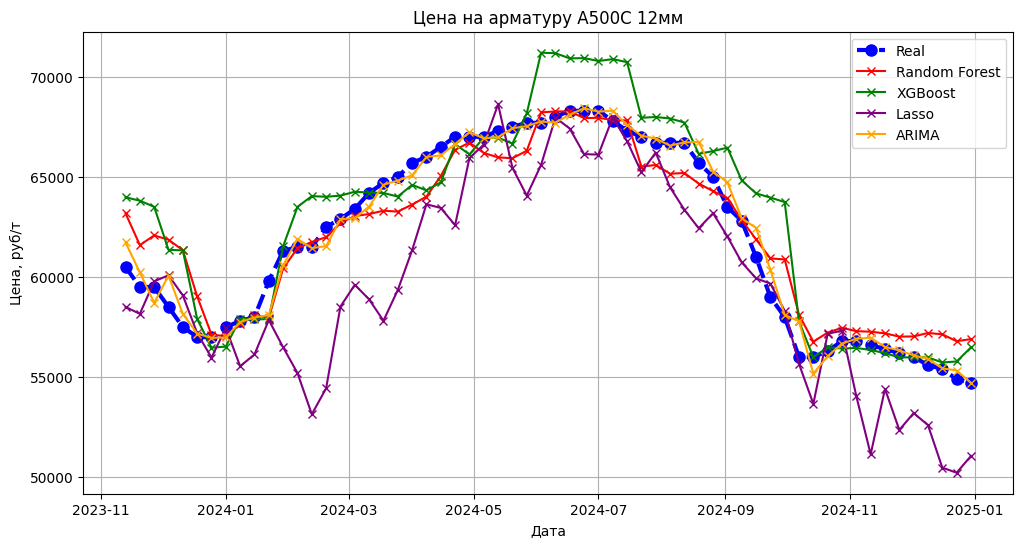

In [ ]:
train_and_test(df, models, colors, 60)

In [ ]:
total_results = pd.read_csv(r'./summary_models_results.csv')

FileNotFoundError: [Errno 2] No such file or directory: './summary_models_results.csv'

In [ ]:
total_results

,Модель,Затраты по стратегии (прогнозная цена),Затраты по стратегии (реальная цена закупки),Затраты при покупке каждую неделю (идеал),Экономия/потери стратегии (реальная цена закупки)
0,Random Forest,3.136380e+06,3134000.0,3134000.0,0.0
1,XGBoost,3.125923e+06,3134000.0,3134000.0,0.0
2,Lasso,3.048799e+06,3134000.0,3134000.0,0.0
3,ARIMA,3.136083e+06,3134000.0,3134000.0,0.0


In [ ]:
total_results.to_excel('Затраты посмотреть.xlsx', index=False)